<a href="https://colab.research.google.com/github/ecohydro/DroughtEDM/blob/master/Notebooks/EDM/growing_season_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This repository contains functions for generating the prediction skill across East Africa on the Administrative Level 1 Level and computing a pixelwise evaluation of prediction skill using EDM across Africa for a given environmental variable

- To do: 
    - look at sensitivity of ED on spatial scale and then adjust pixelwise analysis so that it is using the optimal ED for each pixel
    - what to do about gaps in time series 
    
    
    http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-QuickUserGuide-LC-Maps_v2-0-7.pdf

In [ ]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime
import random

In [ ]:
croplands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Croplands/'
grasslands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Grasslands/'
savannas_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Savannas/'
cropnatveg_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_CropNatVeg/'
EA_TS_DIR = '/home/rgreen/DroughtEDM/Data/EA_TS/Final/'

Africa_simplex = '/home/rgreen/DroughtEDM/Data/Africa_simplex/' #out directory

Admin_boundaries = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/AdminBoundaries/'

In [ ]:
precip_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Compressed/' #[0:522]
temp_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Compressed/'
ndvi_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Compressed/' #[0:522]

precip_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/EA/'
temp_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/EA/'
ndvi_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/EA/'

In [ ]:
precip_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/'
temp_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly/'
ndvi_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/'

In [ ]:
ea_adminbds = Admin_boundaries + 'gadm36_EastAfrica.shp'
ea_bndry = gpd.read_file(ea_adminbds)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Africa_basemap = world[world['continent'] == 'Africa']
EA_countries = ['Burundi', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda', 'Sudan', 'S. Sudan', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda']
EastAfrica_basemap = world[world['name'].isin(EA_countries)]
EastAfrica_basemap.to_file(Admin_boundaries + 'EastAfrica_countries.shp')

In [ ]:
begin = pd.datetime(2002,7,1)
end = pd.datetime(2016,12,31)
dtrange = pd.date_range(begin, end)
days = list(range(0,5298)) #length of dtrange
daysDF = pd.DataFrame({'Days': days}, index=dtrange)
d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
dekads = daysDF.groupby(dekaddates).mean()
dekads = dekads.index

## 2. Generate Anomaly Rasters to remove Climatology

In [ ]:
def stack_rasters(in_dir, keyword):
    
    '''
    This function creates a raster stack xarray DataArray given a specified variable keyword.
    Keywords = 'chirps', 'Tmax', 'ndvi', 'SM', 'pet', 'lst'
    
    '''
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]
    
    stacked = []
    
    for filename in tqdm(files[0:522]): 
        if keyword in filename:
    
            file = xr.open_rasterio(in_dir+filename)
            stacked.append(file.sel(band=1))
            
    combined = xr.concat(stacked, dim = 'time')
  

    return combined.assign_coords(time=dekads)

In [ ]:
#stack_out = stack_rasters(precip_dir, 'chirps')

stack_out = stack_rasters(ndvi_ea, 'ndvi')

100%|██████████| 522/522 [00:02<00:00, 187.38it/s]


In [ ]:
#use this just for NDVI

ds_ndvi = (stack_out-100)/100
ds_anom = ds_ndvi - ds_ndvi.mean(dim = 'time')

#all other variables
#ds_anom = stack_out - stack_out.mean(dim ='time')

In [ ]:
def dataarray2tiff(dataarray, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D xarray DataArray into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile
        
    for i in np.arange(0,522, 1):
        data = np.array(dataarray[i])
       
        with rasterio.open(out_dir + out_name + str(np.array(dataarray[i].time))[:10] + '.tif', 'w', **profile) as dst:
            
            data = data.astype(np.float32)
            dst.write(data, indexes = 1)

In [ ]:
dataarray2tiff(ds_anom, ndvi_ea, ndvi_anom_dir, 'anom_ea_ndvi_')

## 3. Pixelwise Prediction Skill Across Africa

In [ ]:
def pixelwise_ts_table(in_dir, label=None):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['chirps', 'lst', 'ndvi', 'pet', 'SM', 'Tmax']
    '''
    
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]#[0:522]
    n_samples = len(files)
    
    
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
        open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
        array = open_file.values

        # Determine the size of the datatable
        [rs_cols, rs_rows] = array.shape()

        pixel_list = array.ravel().tolist()
   
        pixelwise_TS.append(pixel_list)

        # Create a DataFrame from the pixelwise list:
        table = pd.DataFrame(pixelwise_TS)

        # Add rs_cols and rs_rows as attributes to the table DataFrame
        table.rs_cols = rs_cols
        table.rs_rows = rs_rows
        table.n_samples = n_samples
        if label:
          table.label = label
    return table

    

In [ ]:
precip_table = pixelwise_ts_table(precip_anom_dir, 'precip')
temp_table = pixelwise_ts_table(temp_anom_dir, 'temp')
ndvi_table = pixelwise_ts_table(ndvi_anom_dir, 'ndvi')

100%|██████████| 522/522 [00:08<00:00, 62.54it/s]


In [ ]:


def extract_column(tables, col):
  '''
   This function extracts a column of data from a list of tables and
   combines them into a single dataframe for use in the Simplex function.

   Note: The order of labels must match the order of tables.

  Args:
  - tables: List of input tables, where every column of every table is the time series
   of each pixel in a raster.
  - labels: List of text labels corresponding to each table.
    NOTE: May be able to avoid this, if we assign labels during table creation.

  '''
  table_dict = {
      # Assume all tables are the same size!
      'Time': list(range(0,tables[0].n_samples))
  }
  # Don't overwrite labels if we already assigned them:
  for i, table in enumerate(tables):
    if not hasattr(table, 'label'):
      raise ValueError('Table {table} does not have a label attribute!'.format(
          table=table
      )
  for table in tables:
    table_dict[table.label] = table.iloc[:,col]
  
  return pd.DataFrame(table_dict)


def multi_pixelwise_simplex(tables, train, test, ed, pi):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given multiple tables of different variables of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: list of input tables, where every table has columns with the time series of each pixel in a raster
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
    '''

    simplex_out_df = []
    
    for col in tqdm(range(len(precip_table.columns))):
        interim_df = extract_column(tables, col) 
       
        # interim_df = pd.DataFrame({'Time': list(range(0,522)), 'precip': precip_table.iloc[:,col], 'temp': temp_table.iloc[:,col], 'ndvi': ndvi_table.iloc[:,col]}) 
       
        
        if interim_df.isnull().values.any():
            
            simplex_out_df.append(np.nan)
        else:
            
            
            simplex_result = Simplex(dataFrame = interim_df, lib = train, pred = test, E = ed, Tp = pi, 
                                     columns = 'precip temp ndvi', target = 'ndvi', showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            rho = list(error.values())[2]
            simplex_out_df.append(rho)
            
            
    return(np.reshape(simplex_out_df, (table.rs_rows, table.rs_cols)))
            



In [ ]:
ndvi_ea_simplex1 = multi_pixelwise_simplex('1 100', '101 522', 2, 18, 674, 583)

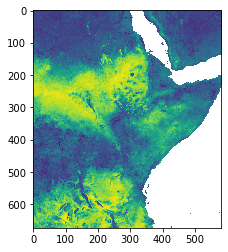

In [ ]:
plt.imshow(ndvi_ea_simplex1)

In [ ]:
def pixelwise_simplex(table, train, test, ed, pi):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: input table, where every column is the time series of each pixel in a raster
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
   
    '''

    simplex_out_df = []
    
    for column in tqdm(table):
       
        if table[column].isnull().values.any():
            
            simplex_out_df.append(np.nan)
        else:
            
            interim_df = pd.DataFrame({'Time': list(range(0,table.n_samples)), 'Data': table[column]}) #'Time': dekads
            simplex_result = Simplex(dataFrame = interim_df, lib = train, pred = test, E = ed, Tp = pi, 
                                     columns = 'Data', target = 'Data', showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            rho = list(error.values())[2]
            simplex_out_df.append(rho) 
            
    return(np.reshape(simplex_out_df, (table.rs_rows, table.rs_cols)))
            



In [ ]:
ndvi_ea_simplex = pixelwise_simplex(ndvi_table, '1 100', '101 522', 2, 18, 674, 583)


#precip_simplex = pixelwise_simplex(precip_table, '1 100', '101 522', 2, 18, 1600, 1500) #1500, 1600

392942it [27:50, 235.18it/s]                      


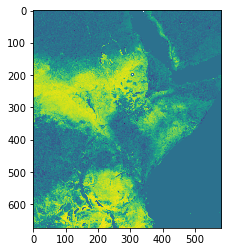

In [ ]:
fig = plt.figure()
plt.imshow(ndvi_ea_simplex)

In [ ]:
# ndvi_crops_africa_simplex = pixelwise_simplex(ndvi_crops_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_crops_africa_simplex = pixelwise_simplex(temp_crops_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_crops_africa_simplex = pixelwise_simplex(precip_crops_table, '1 100', '101 522', 2, 18, 800, 730)

# ndvi_grass_africa_simplex = pixelwise_simplex(ndvi_grass_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_grass_africa_simplex = pixelwise_simplex(temp_grass_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_grass_africa_simplex = pixelwise_simplex(precip_grass_table, '1 100', '101 522', 2, 18, 800, 730)

# ndvi_sav_africa_simplex = pixelwise_simplex(ndvi_sav_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_sav_africa_simplex = pixelwise_simplex(temp_sav_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_sav_africa_simplex = pixelwise_simplex(precip_sav_table, '1 100', '101 522', 2, 18, 800, 730)

In [ ]:
def growing_pixelwise_simplex(table, ed, pi, train_decads, test_decads, n_skips=36): # d1,d2,d3,d4,d5,d6,d7,d8,d9],d10,d11,d12,d13,d14,d15,d16,d17,d18):# ,  train_start_date, train_end_date, test_start_date, test_end_date):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across the time of growing season given the months leading up to the rains
    for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: input table from pixelwise_ts_table result of each pixel's time series
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
    - train_decads: list of decads to use in training
    - test_decads: list of decads to use in testing
    - n_skips: Number of skips between decads (default is 36, which is 1 year)
   
    '''

    n_skips = 36
    simplex_out_df = []
    #table_chunk = table.loc[:100,500:510]
    
    for column in tqdm(table):
        #print(column)
        if table[column].isnull().values.any():
            #print('null')
            simplex_out_df.append(np.nan)
        else:
            #do simplex function on these columns
            #change dekads to just a time list
            interim_df = pd.DataFrame({'Time': dekads, 'Data': table[column]}) #'Time': dekads
            train_list = sorted(list(np.concatenate([np.arange(decad, table.n_samples, n_skips) for decad in train_decads])))
            train_season = interim_df.loc[train_list]
            train_season.reset_index()
            #train_season = interim_df[(interim_df['Time'].dt.month >= train_start_date) & (interim_df['Time'].dt.month <= train_end_date)]
            test_list = sorted(list(np.concatenate([np.arange(decad, table.n_samples, n_skips) for decad in test_decads])))
            test_season = interim_df.loc[test_list]
            #test_season = interim_df[(interim_df['Time'].dt.month >= test_start_date) & (interim_df['Time'].dt.month <= test_end_date)]

            test_season.reset_index()

            
            simplex_result = Simplex(dataFrame = interim_df, lib = str(train_season.index[0]) + ' ' + str(train_season.index[-1]), pred = str(test_season.index[0]) + ' ' + str(test_season.index[-1]), E = ed, Tp = pi, columns = 'Data', target = 'Data', showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            MAE = list(error.values())[0]
            RMSE = list(error.values())[1]
            rho = list(error.values())[2]
            
           
            simplex_out_df.append(rho) #adjust measure depending on output interest
            
    return(np.reshape(simplex_out_df, (table.rs_rows, table.rs_cols)))
            
            




In [ ]:
ond_ndvi = growing_pixelwise_simplex(ndvi_table, 2, 18, 674, 583, train_decads=[9, 10, 11, 12, 13, 14, 15, 16, 17], test_decads=[18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

392942it [53:20, 122.79it/s]                      


In [ ]:
train_decads=[15, 16, 17, 18, 19, 20, 21, 22, 23]
test_decads=[24, 25, 26, 27, 28, 29, 30, 31, 32]
djf_ndvi = growing_pixelwise_simplex(ndvi_table, 2, 18, 674, 563, train_decads, test_decads)

392942it [1:57:03, 55.95it/s]                    


ValueError: cannot reshape array of size 392942 into shape (674,563)

In [ ]:
list(range(15, 33, 1))

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

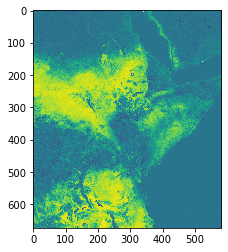

In [ ]:
plt.imshow(ond_ndvi)

In [ ]:
df = pd.DataFrame({'Time': dekads, 'Data': random.sample(range(522),522)}) 

In [ ]:
df.head(10)

,Time,Data
0,2002-07-01,203
1,2002-07-11,84
2,2002-07-21,283
3,2002-08-01,146
4,2002-08-11,225
5,2002-08-21,32
6,2002-09-01,280
7,2002-09-11,492
8,2002-09-21,180
9,2002-10-01,119


In [ ]:
#OND

df.loc[sorted(list(np.arange(,522,36)) + list(np.arange(10,522,36)) + list(np.arange(11,522,36)) + list(np.arange(12,522,36)) + list(np.arange(13,522,36)) + list(np.arange(14,522,36))+ list(np.arange(15,522,36)) + list(np.arange(16,522,36)) + list(np.arange(17,522,36)))]

,Time,Data
9,2002-10-01,119
10,2002-10-11,505
11,2002-10-21,125
12,2002-11-01,166
13,2002-11-11,86
14,2002-11-21,267
15,2002-12-01,501
16,2002-12-11,441
17,2002-12-21,87
45,2003-10-01,93


In [ ]:
#pre OND

df.loc[sorted(list(np.arange(0,522,36)) + list(np.arange(1,522,36)) + list(np.arange(2,522,36)) + list(np.arange(3,522,36)) + list(np.arange(4,522,36)) + list(np.arange(5,522,36))+ list(np.arange(6,522,36)) + list(np.arange(7,522,36)) + list(np.arange(8,522,36)))].head(20)

,Time,Data
0,2002-07-01,203
1,2002-07-11,84
2,2002-07-21,283
3,2002-08-01,146
4,2002-08-11,225
5,2002-08-21,32
6,2002-09-01,280
7,2002-09-11,492
8,2002-09-21,180
36,2003-07-01,425


In [ ]:
#temp_africa_simplex = pixelwise_simplex(temp_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_africa_simplex = pixelwise_simplex(precip_table, '1 100', '101 522', 2, 18, 800, 730)
# ndvi_africa_simplex = pixelwise_simplex(ndvi_table, '1 100', '101 522', 2, 18, 800, 730)

#sm_africa_simplex = pixelwise_simplex(sm_table, '1 100', '101 522', 2, 18, 800, 730)
#lst_africa_simplex = pixelwise_simplex(lst_table, '1 100', '101 522', 2, 18, 800, 730)
#pet_africa_simplex = pixelwise_simplex(pet_table, '1 100', '101 522', 2, 18, 800, 730)



584000it [01:22, 7039.39it/s]                      


convert array to raster to save out

In [ ]:
def array2tiff(array, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D array into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile

    with rasterio.open(out_dir + out_name + '.tif', 'w', **profile) as dst:
        data = array
        data = data.astype(np.float32)
        #data[data<=0] = np.nan
        dst.write(data, indexes=1)
    


In [ ]:
array2tiff(ndvi_ea_simplex, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_uni')
#array2tiff(ndvi_ea_simplex1, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi')

In [ ]:
array2tiff(ond_ndvi, ndvi_ea, Africa_simplex, 'ond_ndvi_uni')

In [ ]:
array2tiff(temp_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'temp_africa_simplex_crop')
array2tiff(precip_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'precip_africa_simplex_crop')
array2tiff(ndvi_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'ndvi_africa_simplex_crop')

array2tiff(temp_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'temp_africa_simplex_grass')
array2tiff(precip_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'precip_africa_simplex_grass')
array2tiff(ndvi_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'ndvi_africa_simplex_grass')

array2tiff(temp_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'temp_africa_simplex_sav')
array2tiff(precip_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'precip_africa_simplex_sav')
array2tiff(ndvi_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'ndvi_africa_simplex_sav')

In [ ]:
array2tiff(ndvi_crops_deyr_rains, croplands_vars_dir, Africa_simplex, 'ndvi_crops_deyr_rains')

Plot

In [ ]:
def mask_raster_shp(shp, raster, out_name, in_dir, out_dir):
    
    '''
    This function masks a raster to the shape of a smaller shapefile and creates a new raster
    
    '''
    with fiona.open(shp, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(in_dir + raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_dir + out_name, "w", **out_meta) as dest:
        
        dest.write(out_image)

In [ ]:
mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_uni.tif', 'ndvi_eastafrica_simplex_uni.tif', Africa_simplex, Africa_simplex)

#mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_multi.tif', 'ndvi_eastafrica_simplex_multi.tif', Africa_simplex, Africa_simplex)

In [ ]:
mask_raster_shp(ea_adminbds, 'ond_ndvi_uni.tif', 'ond_ndvi_eastafrica_uni.tif', Africa_simplex, Africa_simplex)


In [ ]:
mask_raster_shp(ea_adminbds, 'temp_africa_simplex_crop.tif', 'temp_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_africa_simplex_crop.tif', 'precip_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_crop.tif', 'ndvi_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)

mask_raster_shp(ea_adminbds, 'temp_africa_simplex_grass.tif', 'temp_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_africa_simplex_grass.tif', 'precip_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_grass.tif', 'ndvi_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)

mask_raster_shp(ea_adminbds, 'temp_africa_simplex_sav.tif', 'temp_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'precip_africa_simplex_sav.tif', 'precip_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_sav.tif', 'ndvi_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)



Plot East Africa Simplex

In [ ]:
#precip_simplex_tif = rasterio.open(Africa_simplex + 'precip_simplex')

ndvi_simplex_tif_uni = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_uni.tif')
ond_ndvi_uni = rasterio.open(Africa_simplex + 'ond_ndvi_eastafrica_uni.tif')

In [ ]:
temp_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_crop.tif')
precip_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_crop.tif')
ndvi_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_crop.tif')

temp_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_grass.tif')
precip_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_grass.tif')
ndvi_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_grass.tif')

temp_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_sav.tif')
precip_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_sav.tif')
ndvi_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_sav.tif')

[20, 55, -15, 25]

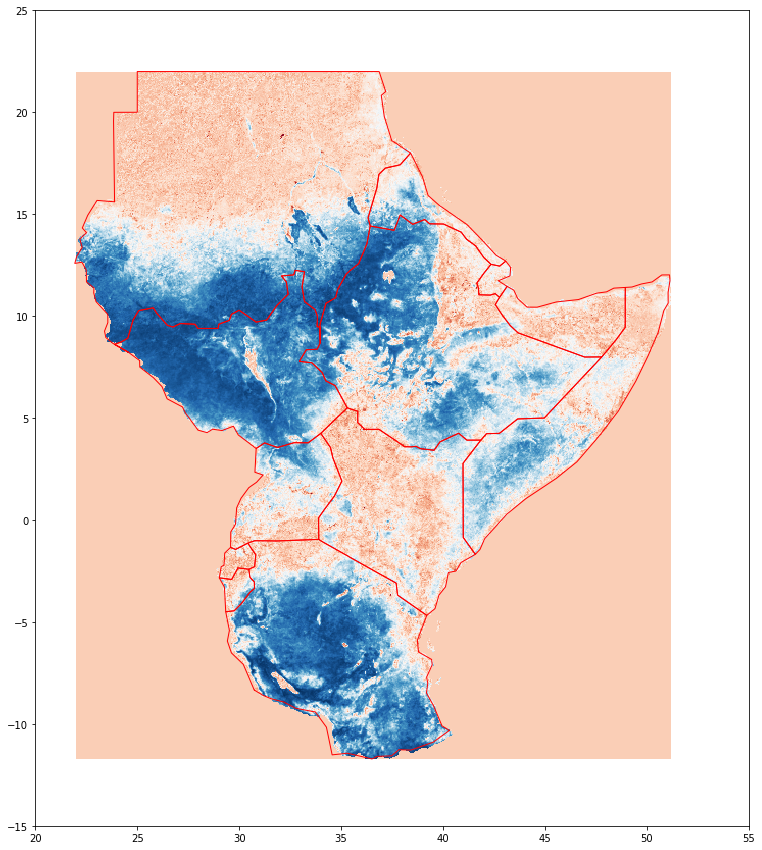

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

show(ndvi_simplex_tif_uni, ax=ax, cmap = 'RdBu')
#show(ond_ndvi_uni, ax=ax, cmap = 'RdBu')


#zoom into East Africa
EastAfrica_basemap.plot(ax=ax, facecolor='none', edgecolor='red')
plt.axis([20, 55,-15,25])


In [ ]:
# raster_list = [temp_eastafrica_simplex_crop_tif, precip_eastafrica_simplex_crop_tif, ndvi_eastafrica_simplex_crop_tif]
# var_list = ['Temperature', 'Precipitation', 'NDVI']

# fig, axs = plt.subplots(1, 3, figsize = (30, 20))
# axs = axs.ravel()
# fig.subplots_adjust(wspace= 0.25, hspace = 0.35)
# fig = plt.gcf()
# for i, raster in enumerate(raster_list):
#     show(raster, ax=axs[i], cmap = 'Blues')
    
    
#     EastAfrica_basemap.plot(ax=axs[i], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)
    
#     axs[i].set_title(var_list[i], fontsize = 25)
    
# plt.savefig('/home/rgreen/ea_simplex_3panel.png', dpi = 300)

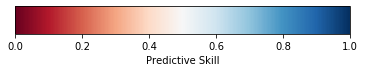

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Predictive Skill')  

plt.savefig('/home/rgreen/colorbar_bugr', dpi = 300)

# 4. Embedding Dimension Spatial Sensitivity 
use Embed Dimension function

In [ ]:
embed_result = EmbedDimension(dataFrame = table, 
                                      lib = train, pred = test, columns = column, showPlot = False)
        max_embed = embed_result.iloc[embed_result['rho'].idxmax()][0]
        print(max_embed)

In [ ]:
def pixelwise_embed_dimension(table, train, test, rs_rows, rs_cols):
    


    embed_max_df = []
    #table_chunk = table.loc[:100,500:510]
    
    for column in tqdm(table):
#         #print(column)
        if table[column].isnull().values.any():
            #print('null')
            embed_max_df.append(np.nan)
        else:
            interim_df = pd.DataFrame({'Time': list(range(0,522)), 'Data': table[column]}) #'Time': dekads
            embed_result = EmbedDimension(dataFrame = interim_df, 
                                      lib = train, pred = test, columns = 'Data', target = 'Data', showPlot = False)
            max_embed = embed_result.iloc[embed_result['rho'].idxmax()][0]
            
            #simplex_result = Simplex(dataFrame = interim_df, lib = train, pred = test, E = ed, Tp = pi, 
                                     #columns = 'Data', target = 'Data', showPlot = False)
#             error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
#             MAE = list(error.values())[0]
#             RMSE = list(error.values())[1]
#             rho = list(error.values())[2]
           
            embed_max_df.append(max_embed) #adjust measure depending on output interest
            
    return(np.reshape(embed_max_df, (rs_rows,rs_cols)))
            

In [ ]:
ndvi_africa_ed = pixelwise_embed_dimension(ndvi_table, '1 100', '101 522', 800, 730)